In [1]:
!pwd

/home/yiyi/Documents/CL/semantikII/project/cdl


In [1]:
pred_arg_types_binary= '/home/yiyi/Documents/CL/semantikII/project/data/pred_arg_types_binary.json'
pred_arg_types_unary= '/home/yiyi/Documents/CL/semantikII/project/data/pred_arg_types_unary.json'

In [2]:
import json
import numpy as np
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
def extract_all_argument_pairs(pred_arg_types_binary):
    with open(pred_arg_types_binary) as fp:
        pred_arg_types_binary_dict= json.load(fp)
        
    pred_arg_types_dict={}    # for each pred, {(loc, pers):[(mc,ls),(us, luis)...]}
    
    pred_args_dict=defaultdict(list) # {'star':[(mc,ls),(us,luis)...]}
    pred_arg_types_distribution={}
    
    arg_all=[]
    type_all=[]
    arg_pairs_all=[]
    type_pairs_all=[]
    for pred, args_dict in pred_arg_types_binary_dict.items():
        type_arg_dict=defaultdict(list)
        arg_pairs=[]
        type_pairs=[]
        for line  in args_dict:
            arg_pair=[]
            types=[]
            
            for index, words_type in sorted(line.items()):
                word, type= words_type
                types.append(type)
                type_all.append(type)
                arg_pair.append(word.lower())
                arg_all.append(word.lower())
            if len(arg_pair)==2:
                arg_pairs.append(tuple(arg_pair))
                type_pairs.append(tuple(types))
                
            if len(arg_pair)==3:
                arg_pairs.append(tuple((arg_pair[0], arg_pair[1])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[2])))
                type_pairs.append(tuple((types[0], types[1])))
                type_pairs.append(tuple((types[0], types[2])))
            
            if len(arg_pair)==4:
                arg_pairs.append(tuple((arg_pair[0], arg_pair[1])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[2])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[3])))
                type_pairs.append(tuple((types[0], types[1])))
                type_pairs.append(tuple((types[0], types[2])))
                type_pairs.append(tuple((types[0], types[3])))
                
        pred_args_dict[pred].extend(arg_pairs)
        
        arg_pairs_all.extend(arg_pairs)
        type_pairs_all.extend(type_pairs)
        
        first_types=[type_pair[0] for type_pair in type_pairs]
        second_types=[type_pair[1] for type_pair in type_pairs]
        
        first_types_counter= Counter(first_types)
        second_types_counter = Counter(second_types)
        pred_arg_types_distribution[pred]={
            'arg0_type':{type_:freq/len(first_types) for type_, freq in first_types_counter.items() },
            'arg1_type':{type_:freq/len(second_types) for type_, freq in second_types_counter.items() }
        }
        
        
        for idx, type_pair in enumerate(type_pairs):
            type_arg_dict[type_pair].append(arg_pairs[idx])
        
        pred_arg_types_dict[pred]=type_arg_dict
    
    pred_type_arg_freq={}
    for pred, type_arg_dict in pred_arg_types_dict.items():
        types_arg_counter={}
        for type_, args in type_arg_dict.items():
            types_arg_counter[type_]=Counter(args)
        pred_type_arg_freq[pred]= types_arg_counter
    return arg_pairs_all, type_pairs_all, arg_all, type_all,  pred_type_arg_freq, pred_arg_types_distribution, pred_args_dict

In [62]:
arg_pairs, type_pairs,arg_all, type_all, pred_arg_types_dict, pred_arg_types_distribution, pred_args_dict = extract_all_argument_pairs(pred_arg_types_binary)
unique_arg_pairs=list(set(arg_pairs))
len(unique_arg_pairs),len(arg_pairs), len(set(type_pairs)), len(pred_arg_types_dict), len(pred_args_dict['star'])

(14859, 15442, 16, 1418, 50)

In [74]:
arg_type_dict={ arg: type_ for arg, type_ in zip(arg_all, type_all)}
# arg_type_dict

In [73]:
# pred_arg_types_distribution

In [40]:
args2id= {pair:idx for idx, pair in enumerate(unique_arg_pairs)}
id2args={idx:pair for idx, pair in enumerate(unique_arg_pairs)}
args2id

{('vattenfall europe', 'krümmel nuclear power plant'): 0,
 ('berlin wall', 'west berlin'): 1,
 ('nazi genocide', 'europe'): 2,
 ('doctor v64', 'nintendo 64'): 3,
 ('chariots of fire', 'british'): 4,
 ('britain', 'india'): 5,
 ('federko', 'blues'): 6,
 ('book of ezra', 'ii chronicles'): 7,
 ('turkish', 'dardanelles'): 8,
 ('anc', 'democratic alliance'): 9,
 ('des moines university', 'des moines'): 10,
 ('news corp', 'prime'): 11,
 ('scotland', 'catholics'): 12,
 ('illinois', 'lincoln'): 13,
 ('francis galton', 'darwin -- wedgwood family'): 14,
 ('flockhart', 'new jersey'): 15,
 ('aegadian islands', 'trapani'): 16,
 ('laertes', 'claudius'): 17,
 ('philip anthony hopkins', 'welsh'): 18,
 ('james nesbitt', 'bloody sunday'): 19,
 ('council on foreign relations', 'hamas'): 20,
 ('the royal academy of turku', 'university of helsinki'): 21,
 ('david rice atchison', 'missouri'): 22,
 ('auburn road', 'buffalo'): 23,
 ('cnd', 'dora russell'): 24,
 ('japanese', 'asian'): 25,
 ('haman', 'jews'): 26

In [27]:
predicates=pred_arg_types_dict.keys()
len(predicates)

1418

In [28]:
ls=[0 for i in range(len(args2id))]

In [29]:
len(ls)

14859

In [72]:
# arg_type_dict={arg:type}
# vectors with augmentation
vector_dict={}
for pred, type_pair_dict in pred_arg_types_dict.items():
    type_vector_dict={}
    arg_type_distribution_dict=pred_arg_types_distribution[pred]

    for type_pair, arg_counter in type_pair_dict.items():
        vector_list=[0 for i in range(len(args2id))]
        
        # initialization with the predictions
        for idx, args in id2args.items():
            arg0, arg1 = args
            type1, type2 = arg_type_dict[arg0], arg_type_dict[arg1]
            
            type1_prob = arg_type_distribution_dict['arg0_type'].get(type1,0)
            type2_prob = arg_type_distribution_dict['arg1_type'].get(type2,0)
            vector_list[idx]=  type1_prob* type2_prob
        
        # which has the arg_pair in typed_predicate
        for arg_pair, freq in arg_counter.items():            
            vector_list[args2id[arg_pair]] += freq 
            
        # type_vector_dict[type_pair]=np.asarray(vector_list)
        pred_type_pair=pred+'-'+type_pair[0]+'-'+type_pair[1]
        vector_dict[pred_type_pair]= np.asarray(vector_list)
        

In [59]:
len(vector_dict.keys())

4560

In [65]:
# without augmentation
vector_pred={}
for pred, arg_pair_list in pred_args_dict.items():
    vector_list=[0 for i in range(len(args2id))]
    for arg_pair in arg_pair_list:
        vector_list[args2id[arg_pair]]+=1
    vector_pred[pred]=np.asarray(vector_list)

In [68]:
keys_pred= []
matrix_pred= []
for key, vector in vector_pred.items():
    keys_pred.append(key)
    matrix_pred.append(vector)

In [69]:
features_pred = np.vstack(matrix_pred)
features_pred.shape

(1418, 14859)

In [70]:
label2id_pred={label:idx for idx, label in enumerate(keys_pred)}
id2label_pred={idx:label for idx, label in enumerate(keys_pred)}
labels_pred= np.array(keys_pred)
labels_pred.shape

(1418,)

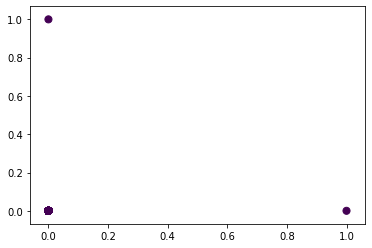

In [71]:
from sklearn.cluster import KMeans
from scipy import sparse

kmeans_pred= KMeans(n_clusters=4)
kmeans_pred.fit(features_pred)
y_kmeans_pred= kmeans.predict(features_pred)
plt.scatter(features_pred[:, 0], features_pred[:, 1],  c=y_kmeans_pred, s=50, cmap='viridis')

In [53]:
keys= []
matrix= []
for key, vector in vector_dict.items():
    keys.append(key)
    matrix.append(vector)
    

In [54]:
features=np.vstack(matrix)
features.shape

(4560, 14859)

In [55]:
label2id={label:idx for idx, label in enumerate(keys)}
id2label={idx:label for idx, label in enumerate(keys)}

In [56]:
labels=np.asarray(keys)
labels.shape

(4560,)

In [57]:
from sklearn.cluster import KMeans
from scipy import sparse

kmeans= KMeans(n_clusters=4)
kmeans.fit(features)
y_kmeans= kmeans.predict(features)


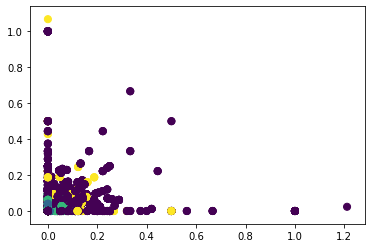

In [58]:
plt.scatter(features[:, 0], features[:, 1],  c=y_kmeans, s=50, cmap='viridis')

In [ ]:


with open(pred_arg_types_binary) as fp:
        pred_arg_types_binary_dict= json.load(fp)
